In [1]:
import h5py
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
#Parameters
batch_size = 16
accurate_loss_baseline = 0.0002

# Paths
path = "solutions"
training_data_path = "2D_ConvAE_results/ConvAE_trainingData_Gadi.txt"
encoder_path = "2D_ConvAE_results/Conv2D_encoder_best_Gadi.pth"
decoder_path = "2D_ConvAE_results/Conv2D_decoder_best_Gadi.pth"

In [3]:
# Temperature for the two consecutive timestamp
temperature_fields = []
  
# Read text File  
def read_text_file(file_path):
    with h5py.File(file_path, 'r') as f:
        temperature_fields.append(f['temperature'][:])
        
        
# Iterate through all file
for file in os.listdir(path):
    file_path = f"{path}/{file}"
  
    # call read text file function
    read_text_file(file_path)
    #print(f"{file_path} is finished reading")
    
temperature_fields = np.asarray(temperature_fields).reshape(10000,201,401)

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
print("Current device is ",device)

# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device is  cpu


In [5]:
# Customised Dataset class
class KMNIST(Dataset):
    
    def __init__(self,dataset):
        # Load the data from two consecutive timestamps of temperature 
        self.data = dataset
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_item = self.data[index]
        
        return data_item

In [6]:
temperature_dataset = KMNIST(
    temperature_fields
)


generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset, validation_dataset = random_split(temperature_dataset, [0.8,0.1,0.1], generator = generator)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size = batch_size,
    shuffle = False
)

validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [7]:
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :201, :]
    
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential( # 201x401 => 
            nn.Conv2d(1, 3, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
            #nn.BatchNorm2d(3),
            nn.Conv2d(3, 6, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
            #nn.BatchNorm2d(6),
            #nn.Conv2d(6, 9, stride=(3, 3), kernel_size=(5, 5), padding=2),
            #nn.Tanh(),
            #nn.BatchNorm2d(9), 
        )
        
    def forward(self, x):
        out=self.encoder(x)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential( # 201x401 => 
            #nn.ConvTranspose2d(9, 6, stride=(3, 3), kernel_size=(5, 5), padding=(2,1)),
            #nn.Tanh(),
            #nn.BatchNorm2d(6),
            nn.ConvTranspose2d(6, 3, stride=(3, 3), kernel_size=(5, 5), padding=(2,2)),
            nn.Tanh(),
            #nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 1, stride=(3, 3), kernel_size=(5, 5), padding=(1,0)),
            #nn.Tanh(),
            #nn.BatchNorm2d(1),
            #Trim(),
        )
        

    def forward(self, x):
        out=self.decoder(x)
        return out

In [8]:
def test(encoder, decoder, test_loader, device, color_regions):
    
    correct = 0
    total = 0
    criterion = nn.MSELoss()
    total_loss = 0.0
    
    best_worst_error_list = [1000000, 0]
    best_worst_input_list = [0, 0]
    best_worst_output_list = [0, 0]
    best_worst_predicted_list = [0, 0]
    
    with torch.no_grad():
        for data in test_loader:
            inputs = data.to(device)
            inputs = inputs.view(inputs.shape[0], 1, 201,401)
                
            # Get output features and calculate loss
            outputs = encoder(inputs)
            outputs = decoder(outputs)
            loss = criterion(outputs, inputs)
                
            # If the loss value is less than 0.01, we consider it being accurate
            for j in range(len(inputs)):
                single_loss = criterion(outputs[j], inputs[j])
                if single_loss.item() <= accurate_loss_baseline:
                    correct += 1
                total += 1
                
                # Record worst error
                if single_loss.item() > best_worst_error_list[1]:
                    best_worst_error_list[1] = single_loss.item()
                    best_worst_input_list[1] = inputs[j]
                    best_worst_predicted_list[1] = outputs[j]
                    
                # Record best error
                if single_loss.item() < best_worst_error_list[0]:
                    best_worst_error_list[0] = single_loss.item()
                    best_worst_input_list[0] = inputs[j]
                    best_worst_predicted_list[0] = outputs[j]
                    

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is",total_loss)
    print("Accuracy for the model is", 100*correct//total)
    print()
    
    # Draw some plots for the best and the worst error
    print("Best model has a error of ", best_worst_error_list[0])
    #print(max(best_worst_input_list[0].detach().numpy()[0].flatten()))
    #print(max(best_worst_predicted_list[0].detach().numpy()[0].flatten()))
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case input")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    if color_regions == 1:
        ax.imshow(best_worst_input_list[0].detach().numpy()[0],
                  cmap=cm.get_cmap('jet', 10),
                  extent=(0, 2, 0, 1))
    else:
        ax.imshow(best_worst_input_list[0].detach().numpy()[0],
                  extent=(0, 2, 0, 1))

    ax.invert_yaxis()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case predicted output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    if color_regions == 1:
        ax.imshow(best_worst_predicted_list[0].detach().numpy()[0],
                  cmap=cm.get_cmap('jet', 10),
                  extent=(0, 2, 0, 1))
    else:
        ax.imshow(best_worst_predicted_list[0].detach().numpy()[0],
                  extent=(0, 2, 0, 1))
        
    ax.invert_yaxis()
    plt.show()
    
    
    print("Worst model has a error of ", best_worst_error_list[1])
    #print(max(best_worst_input_list[1].detach().numpy()[0].flatten()))
    #print(max(best_worst_predicted_list[1].detach().numpy()[0].flatten()))
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case input")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    if color_regions == 1:
        ax.imshow(best_worst_input_list[1].detach().numpy()[0],
                  cmap=cm.get_cmap('jet', 10),
                  extent=(0, 2, 0, 1))
    else:
        ax.imshow(best_worst_input_list[1].detach().numpy()[0],
                  extent=(0, 2, 0, 1))

    ax.invert_yaxis()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case predicted output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    if color_regions == 1:
        ax.imshow(best_worst_predicted_list[1].detach().numpy()[0],
                  cmap=cm.get_cmap('jet', 10),
                  extent=(0, 2, 0, 1))
    else:
        ax.imshow(best_worst_predicted_list[1].detach().numpy()[0],
                  extent=(0, 2, 0, 1))

    ax.invert_yaxis()
    plt.show()

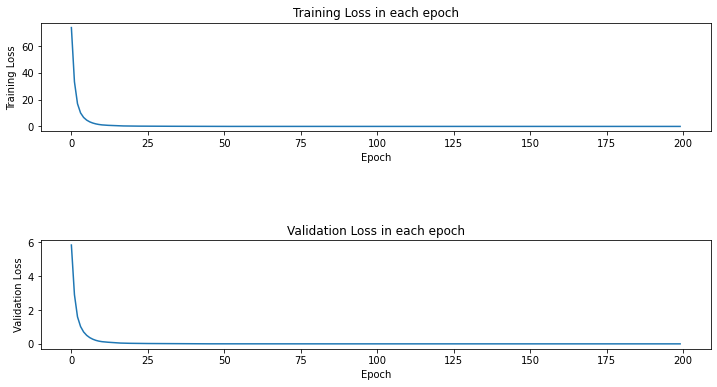

In [9]:
file1 = open(training_data_path, 'r')
Lines = file1.readlines()

training_data_list = []
for line in Lines:
    training_data_list.append([float(x) for x in line.strip().split('/')])
    
# Plot the Training loss and validation loss during training
plt.figure(figsize=(12, 6))
    
plt.subplot(2, 1, 1)
plt.plot(training_data_list[0])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss in each epoch')

plt.subplot(2, 1, 2)
plt.plot(training_data_list[1])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss in each epoch')
    
plt.subplots_adjust(hspace=1)
    
plt.show()

In [10]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(decoder_path, map_location=torch.device('cpu')))

<All keys matched successfully>

Total loss for the model is 0.0037020310410298407
Accuracy for the model is 100

Best model has a error of  1.5686246115365066e-06


<ipython-input-8-4d305cad250d>:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


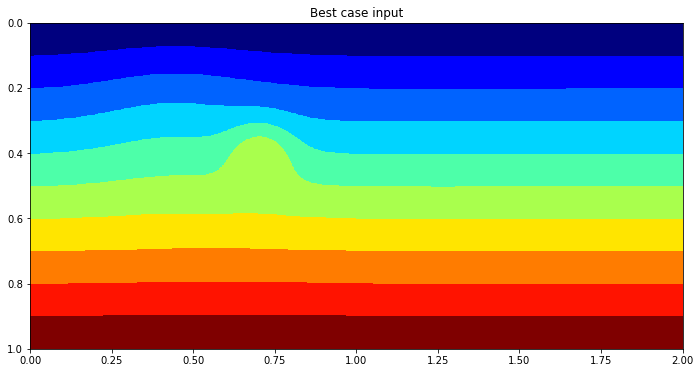

<ipython-input-8-4d305cad250d>:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


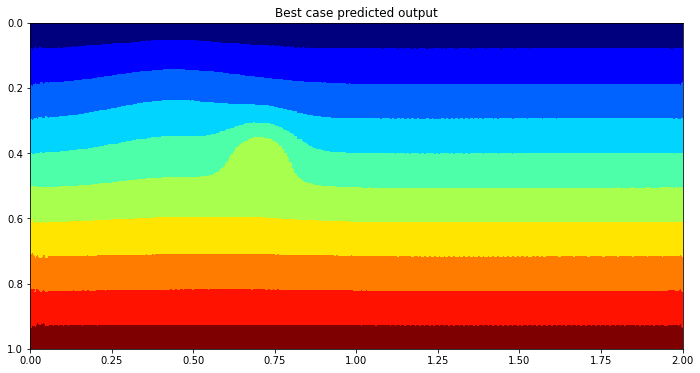

Worst model has a error of  7.95179366832599e-05


<ipython-input-8-4d305cad250d>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


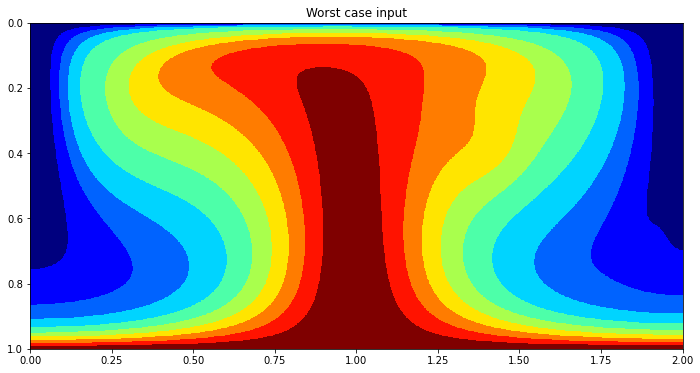

<ipython-input-8-4d305cad250d>:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


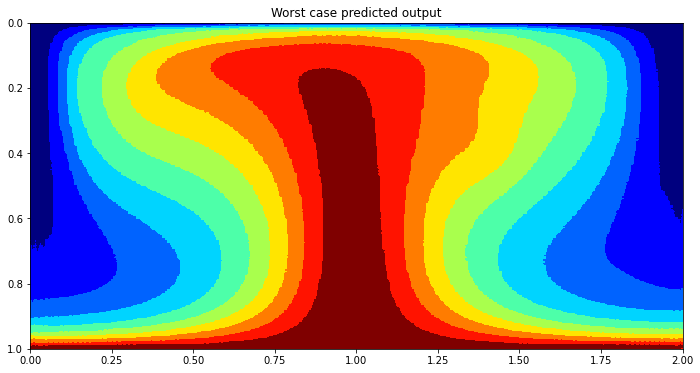

In [11]:
test(encoder, decoder, train_loader, device, 1)

Total loss for the model is 0.0004674463507399196
Accuracy for the model is 100

Best model has a error of  1.5708957334936713e-06


<ipython-input-8-4d305cad250d>:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


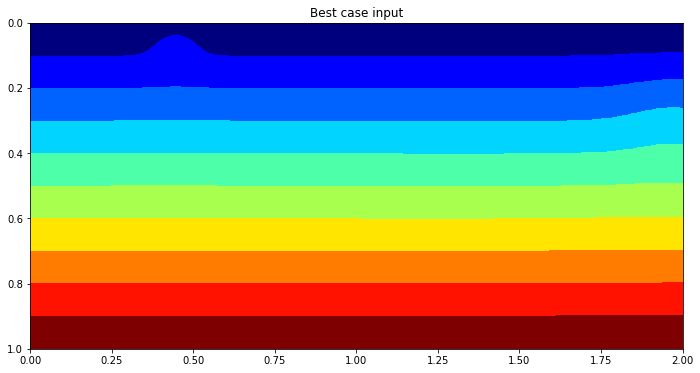

<ipython-input-8-4d305cad250d>:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


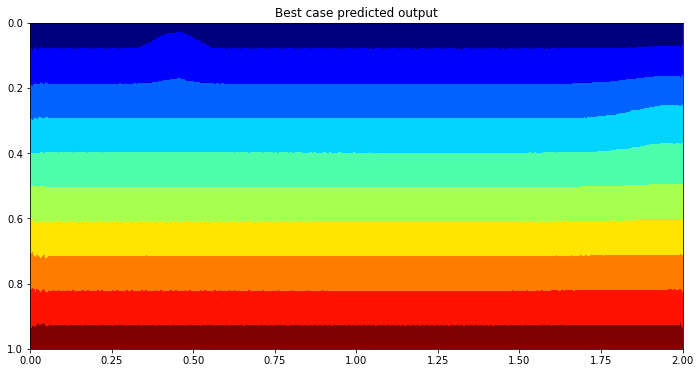

Worst model has a error of  6.807058525737375e-05


<ipython-input-8-4d305cad250d>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


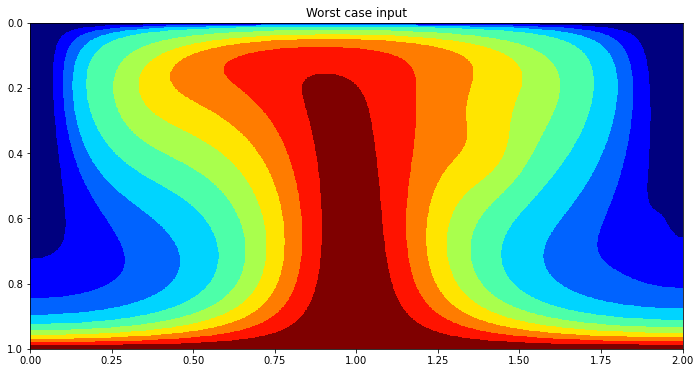

<ipython-input-8-4d305cad250d>:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


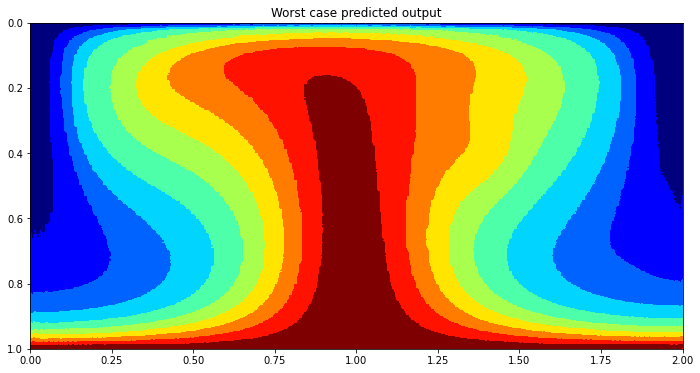

In [12]:
test(encoder, decoder, test_loader, device, 1)